In [47]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# === 1. Richiesta API Eurostat per l'Italia ===
URL = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/namq_10_gdp?format=JSON&geo=IT&unit=CP_MEUR&na_item=B1GQ&s_adj=NSA&lang=en"

try:
    response_API = requests.get(URL)
    response_API.raise_for_status()
    print("✅ Status code:", response_API.status_code)
except requests.exceptions.HTTPError as err:
    raise SystemExit(f"❌ HTTP Error: {err}")


✅ Status code: 200


In [48]:
# === 2. Estrai e prepara ===
gdp_data = pd.DataFrame(list(obj["value"].items()), columns=["Key", "GDP"])
gdp_data["Key"] = gdp_data["Key"].astype(int)

quarter_map = pd.DataFrame(list(obj["dimension"]["time"]["category"]["index"].items()), columns=["Quarter", "Key"])
quarter_map["Key"] = quarter_map["Key"].astype(int)

In [69]:
# 🔧 3. Converte '1995Q1' → datetime fine trimestre
quarter_map["Quarter"] = pd.PeriodIndex(quarter_map["Quarter"], freq='Q').to_timestamp(how="end")

# 🔗 4. Merge e indicizzazione corretta
df = pd.merge(gdp_data, quarter_map, on="Key").drop(columns="Key")
df = df.set_index("Quarter").sort_index()
df.index.name = "Date"

# 🧼 5. Normalizza per rimuovere i nanosecondi
df.index = df.index.normalize()

# 🔁 6. Interpolazione mensile (funzionante!)
df_monthly = df.resample("ME").interpolate(method="linear")
df_monthly["Month"] = df_monthly.index

# ✅ Verifica
print(df_monthly.head(12))
print("NaN trovati:", df_monthly['GDP'].isna().sum())

                      GDP      Month
Date                                
1995-03-31  211263.500000 1995-03-31
1995-04-30  212188.200000 1995-04-30
1995-05-31  213112.900000 1995-05-31
1995-06-30  214037.600000 1995-06-30
1995-07-31  217149.666667 1995-07-31
1995-08-31  220261.733333 1995-08-31
1995-09-30  223373.800000 1995-09-30
1995-10-31  232770.666667 1995-10-31
1995-11-30  242167.533333 1995-11-30
1995-12-31  251564.400000 1995-12-31
1996-01-31  245705.933333 1996-01-31
1996-02-29  239847.466667 1996-02-29
NaN trovati: 0


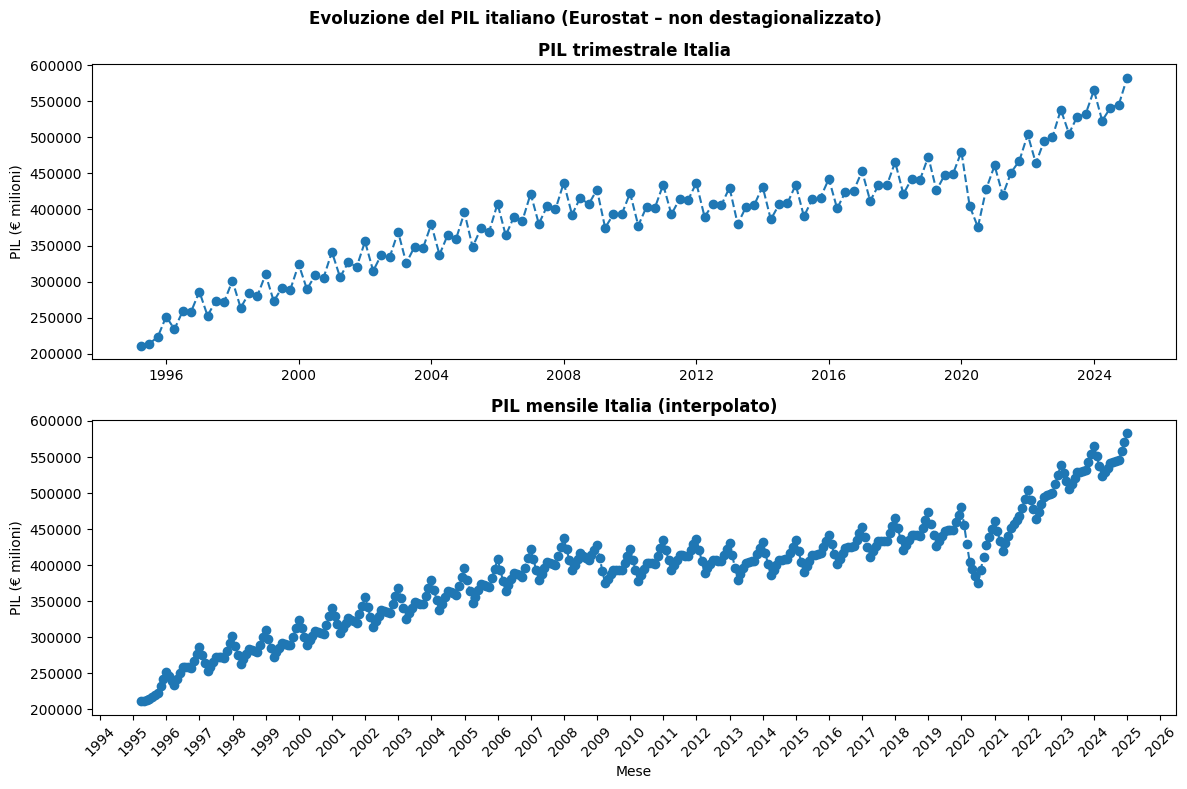

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, figsize=(12, 8))

# Grafico trimestrale originale
ax[0].plot(df.index, df['GDP'], linestyle="--", marker="o")
ax[0].set_title("PIL trimestrale Italia", fontweight='bold')
ax[0].set_ylabel("PIL (€ milioni)")

# Grafico interpolato mensile
ax[1].plot(df_monthly.index, df_monthly['GDP'], linestyle="--", marker="o")
ax[1].set_title("PIL mensile Italia (interpolato)", fontweight='bold')
ax[1].set_ylabel("PIL (€ milioni)")
ax[1].set_xlabel("Mese")

# 👇 Migliora leggibilità dell’asse x nel grafico mensile
ax[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))  # mostra solo gennaio di ogni anno
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].tick_params(axis='x', rotation=45)

# Titolo generale
fig.suptitle("Evoluzione del PIL italiano (Eurostat – non destagionalizzato)", fontweight='bold')
plt.tight_layout()
plt.show()


## Previsione con regressione lineare (sklearn)

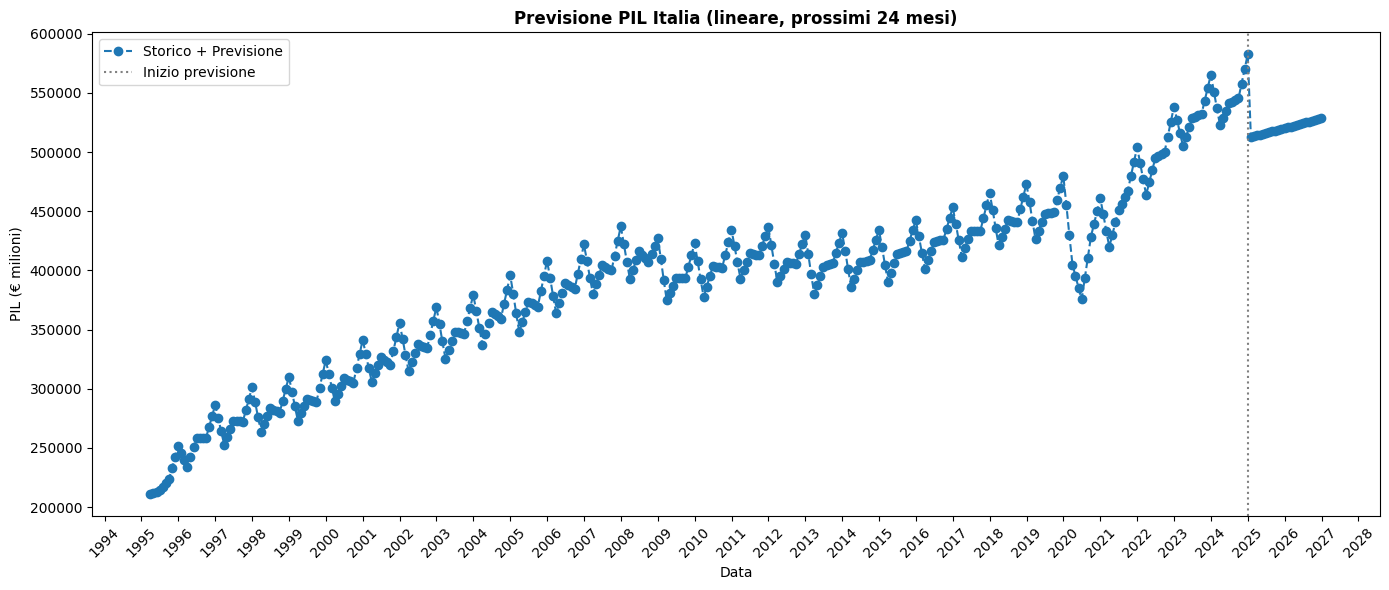

In [72]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Prepara i dati
df_forecast = df_monthly.copy()
df_forecast = df_forecast.dropna()

# 2. Crea una variabile tempo numerica
df_forecast["t"] = np.arange(len(df_forecast)).reshape(-1, 1)
X = df_forecast["t"].values.reshape(-1, 1)
y = df_forecast["GDP"]

# 3. Modello di regressione lineare
model = LinearRegression()
model.fit(X, y)

# 4. Previsione per i prossimi 24 mesi
future_t = np.arange(len(df_forecast), len(df_forecast) + 24).reshape(-1, 1)
future_dates = pd.date_range(start=df_forecast.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME')
future_pred = model.predict(future_t)

# 5. Crea DataFrame della previsione
df_future = pd.DataFrame({
    "GDP": future_pred,
    "Month": future_dates
}, index=future_dates)

# 6. Unisci con la serie storica
df_all = pd.concat([df_forecast[["GDP", "Month"]], df_future])

# 7. Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_all.index, df_all['GDP'], label='Storico + Previsione', linestyle="--", marker="o")
ax.axvline(x=df_forecast.index[-1], color='gray', linestyle=':', label="Inizio previsione")
ax.set_title("Previsione PIL Italia (lineare, prossimi 24 mesi)", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


## Regressione polinomiale (PIL mensile)

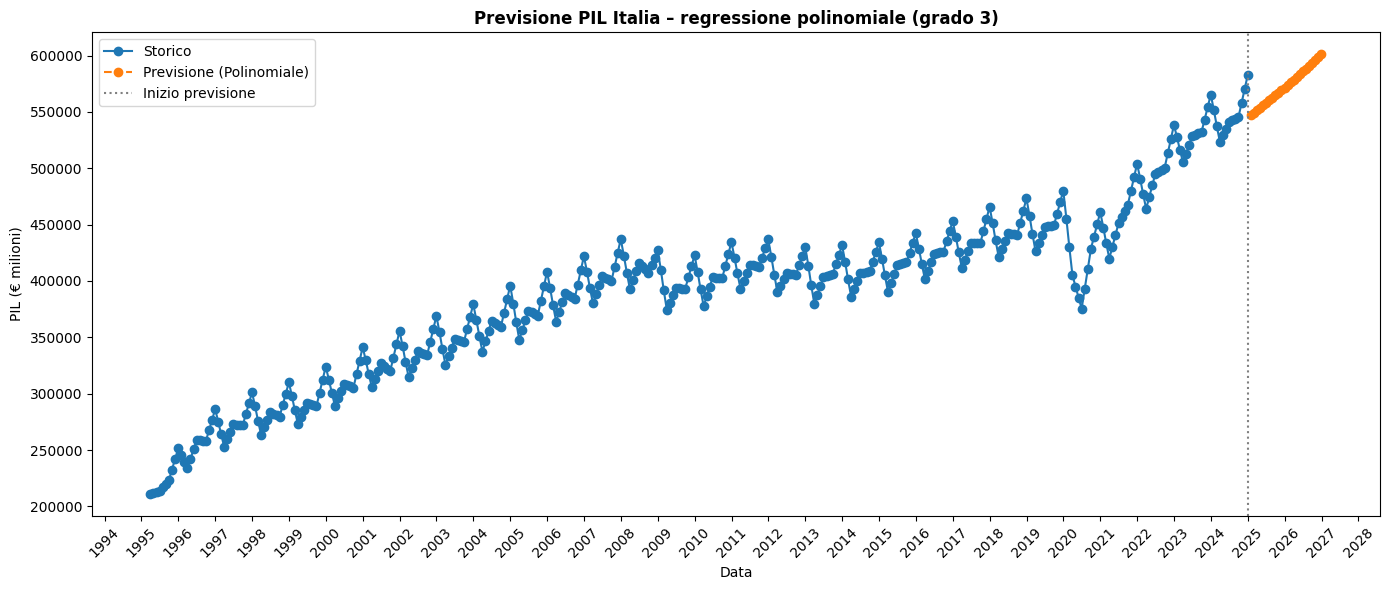

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Prepara i dati
df_poly = df_monthly.copy().dropna()
df_poly["t"] = np.arange(len(df_poly))

X = df_poly["t"].values.reshape(-1, 1)
y = df_poly["GDP"].values

# 2. Trasforma in caratteristiche polinomiali (grado 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# 3. Fit modello
model = LinearRegression()
model.fit(X_poly, y)

# 4. Previsione 24 mesi avanti
future_t = np.arange(len(df_poly), len(df_poly) + 24).reshape(-1, 1)
future_X_poly = poly.transform(future_t)
future_pred = model.predict(future_X_poly)

# 5. Costruisci DataFrame della previsione
future_dates = pd.date_range(start=df_poly.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME')
df_forecast = pd.DataFrame({
    'GDP': future_pred,
    'Month': future_dates
}, index=future_dates)

# 6. Unisci con la serie storica
df_all = pd.concat([df_poly[['GDP']], df_forecast])

# 7. Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_poly.index, df_poly['GDP'], label='Storico', linestyle='-', marker='o')
ax.plot(df_forecast.index, df_forecast['GDP'], label='Previsione (Polinomiale)', linestyle='--', marker='o')
ax.axvline(x=df_poly.index[-1], color='gray', linestyle=':', label="Inizio previsione")

ax.set_title("Previsione PIL Italia – regressione polinomiale (grado 3)", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


## crescita logistica

📈 Parametri stimati: L=560043, k=0.0061, t0=30.3


<positron-console-cell-63>:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


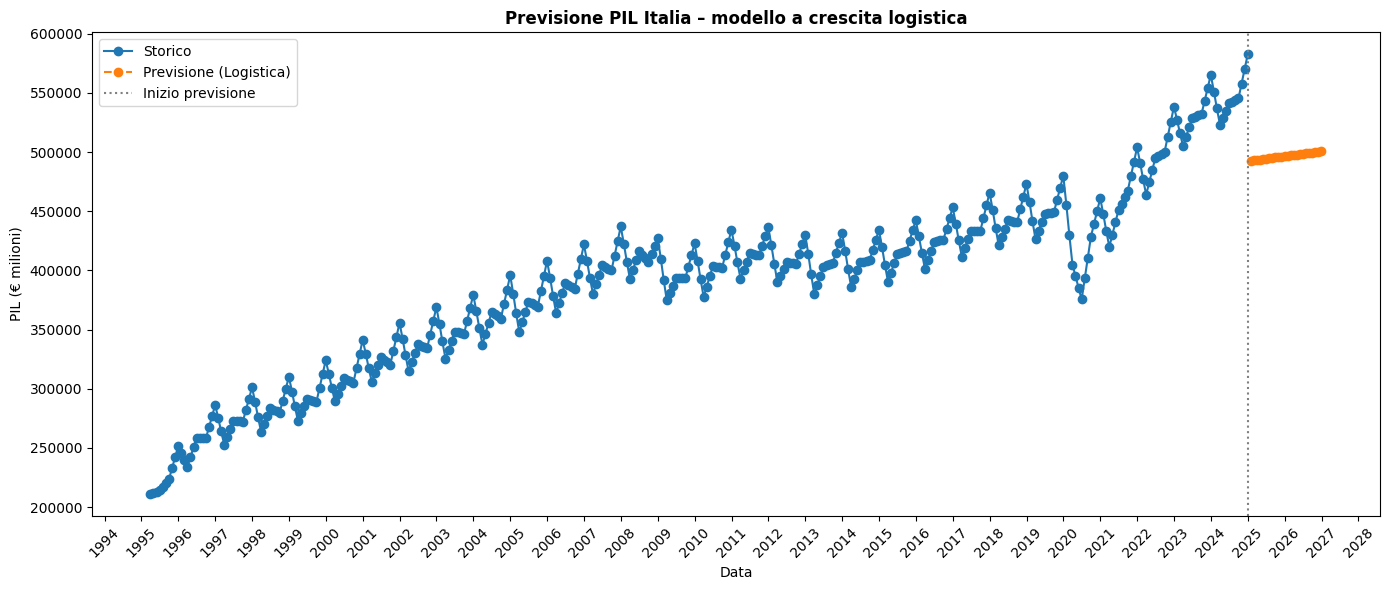

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.dates as mdates

# 1. Definizione della funzione logistica
def logistic(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

# 2. Prepara i dati storici
df_log = df_monthly.copy().dropna()
df_log["t"] = np.arange(len(df_log))  # tempo numerico
t = df_log["t"].values
y = df_log["GDP"].values

# 3. Stima parametri con curve_fit
p0 = [max(y)*1.1, 0.03, len(t)/2]  # stime iniziali: L, k, t0
params, _ = curve_fit(logistic, t, y, p0=p0, maxfev=10000)
L, k, t0 = params
print(f"📈 Parametri stimati: L={L:.0f}, k={k:.4f}, t0={t0:.1f}")

# 4. Previsione futura
t_future = np.arange(len(t) + 24)
y_future = logistic(t_future, L, k, t0)

# 5. Costruisci DataFrame completo
future_dates = pd.date_range(start=df_log.index[0], periods=len(t_future), freq='M')
df_all = pd.DataFrame({
    "GDP": y_future,
    "Month": future_dates
}, index=future_dates)

# 6. Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_log.index, df_log['GDP'], label='Storico', linestyle='-', marker='o')
ax.plot(df_all.index[len(t):], df_all['GDP'].iloc[len(t):], label='Previsione (Logistica)', linestyle='--', marker='o')
ax.axvline(x=df_log.index[-1], color='gray', linestyle=':', label="Inizio previsione")

ax.set_title("Previsione PIL Italia – modello a crescita logistica", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


## Previsione con Modello: ARIMA (AutoRegressive Integrated Moving Average)

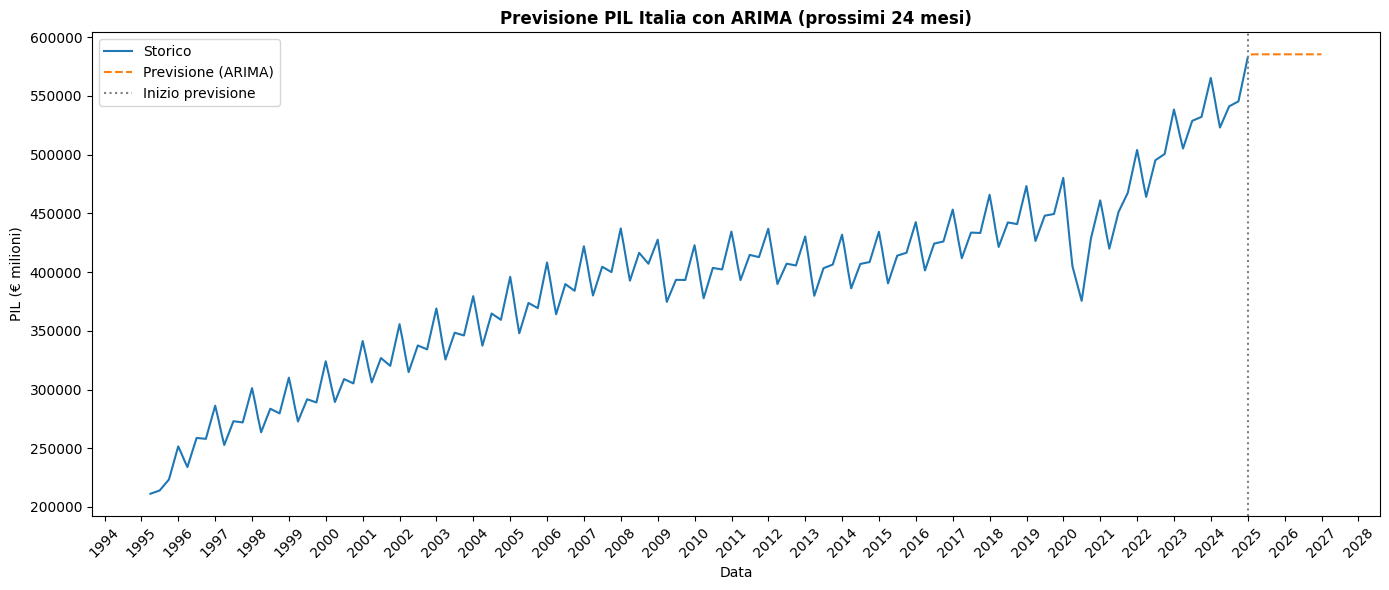

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Usa la serie mensile già interpolata
series = df_monthly['GDP'].dropna()

# Fit modello ARIMA(p,d,q) - partiamo semplice con (1,1,1)
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast per i prossimi 24 mesi
forecast = model_fit.forecast(steps=24)

# Costruisci DataFrame con le date future
future_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME')
df_forecast = pd.DataFrame({
    'GDP': forecast.values,
    'Month': future_dates
}, index=future_dates)

# Combina storico + previsione
df_all = pd.concat([df_monthly[['GDP']], df_forecast])

# Grafico
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_monthly.index, df_monthly['GDP'], label='Storico', linestyle='-')
ax.plot(df_forecast.index, df_forecast['GDP'], label='Previsione (ARIMA)', linestyle='--')
ax.axvline(x=series.index[-1], color='gray', linestyle=':', label="Inizio previsione")

ax.set_title("Previsione PIL Italia con ARIMA (prossimi 24 mesi)", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


### SARIMA 
SARIMA (Seasonal ARIMA), ideale per serie economiche con cicli stagionali come il PIL.

SARIMA = ARIMA + componente stagionale

- ARIMA(p,d,q) gestisce trend e autoregressione

- SARIMA(P,D,Q,s) gestisce stagionalità con periodo s (es: 12 per mesi, 4 per trimestri)

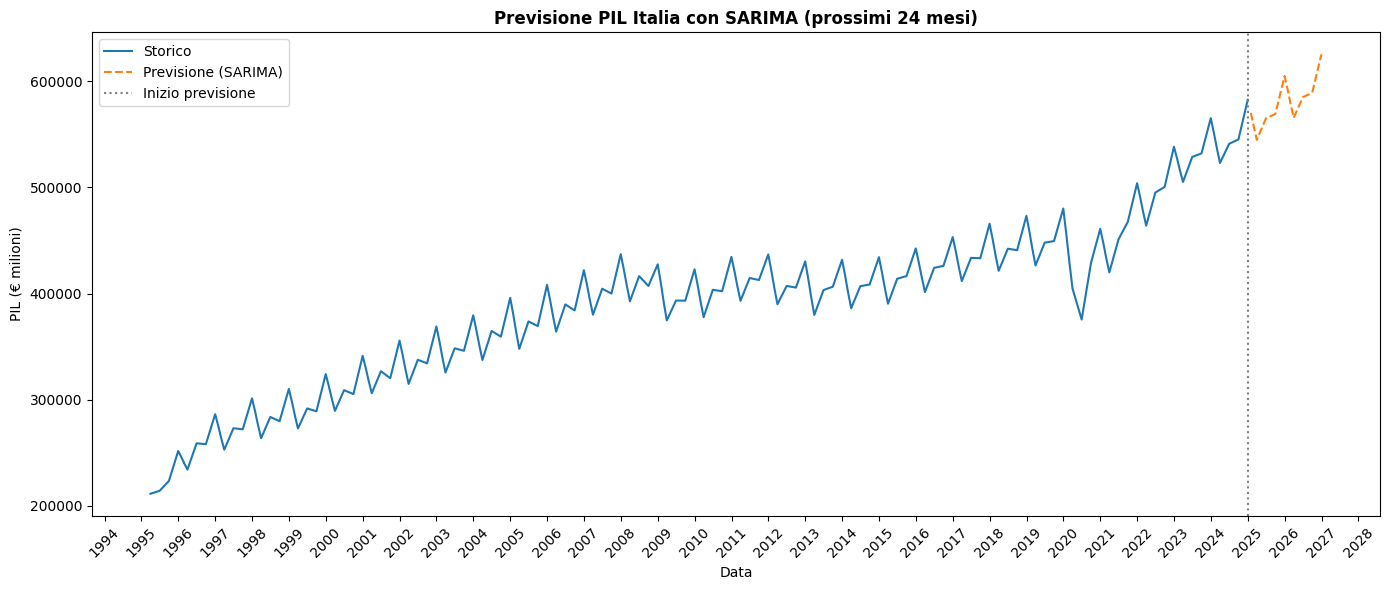

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# 1. Serie pulita
series = df_monthly['GDP'].dropna()

# 2. Modello SARIMA(p,d,q)(P,D,Q,s)
model = SARIMAX(
    series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)

# 3. Previsione per 24 mesi
forecast = model_fit.forecast(steps=24)

# 4. Date future
future_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME')
df_forecast = pd.DataFrame({
    'GDP': forecast.values,
    'Month': future_dates
}, index=future_dates)

# 5. Unisci storico + previsione
df_all = pd.concat([df_monthly[['GDP']], df_forecast])

# 6. Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_monthly.index, df_monthly['GDP'], label='Storico', linestyle='-')
ax.plot(df_forecast.index, df_forecast['GDP'], label='Previsione (SARIMA)', linestyle='--')
ax.axvline(x=series.index[-1], color='gray', linestyle=':', label="Inizio previsione")

ax.set_title("Previsione PIL Italia con SARIMA (prossimi 24 mesi)", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


## Previsione PIL Italia (mensile) con Prophet

perfetto per:

- ✅ serie temporali con **trend + stagionalità**
- ✅ **previsioni interpretabili**
- ✅ gestione automatica di **intervalli di confidenza**, **vacanze**, **outlier**
- ✅ ottimo per serie **mensili, trimestrali, giornaliere**

- Grafico con area di confidenza e trend predetto
- Componenti della previsione:
    - trend a lungo termine
    - stagionalità annuale (se rilevante)

20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing


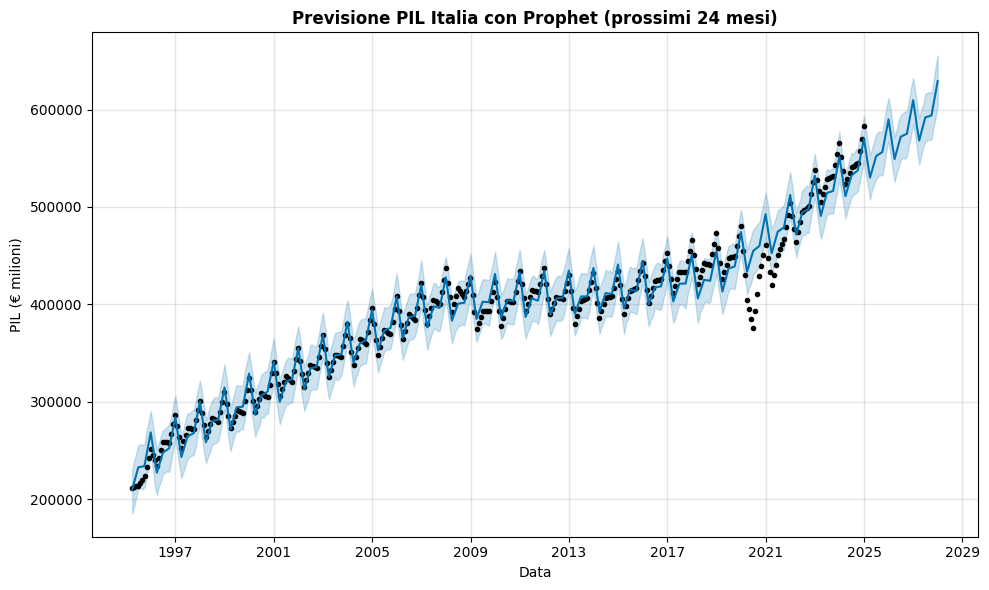

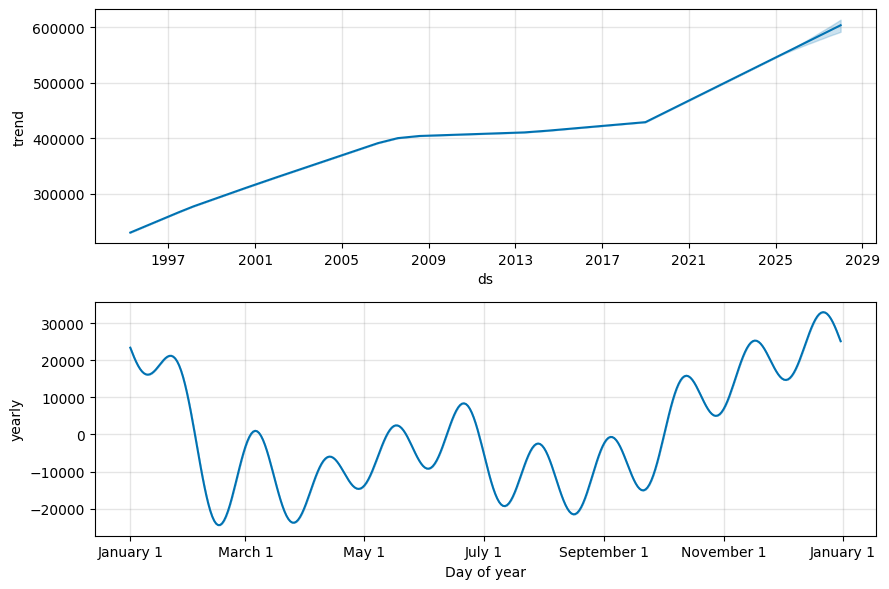

In [77]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Prepara i dati nel formato richiesto
df_prophet = df_monthly.reset_index()[["Date", "GDP"]].dropna()
df_prophet.columns = ["ds", "y"]  # Prophet richiede colonne ds (date) e y (valore)

# 2. Istanzia e allena il modello
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.95
)
model.fit(df_prophet)

# 3. Crea il DataFrame futuro (24 mesi avanti)
future = model.make_future_dataframe(periods=36, freq='ME')

# 4. Previsione
forecast = model.predict(future)

# 5. Visualizza risultato
fig1 = model.plot(forecast)
plt.title("Previsione PIL Italia con Prophet (prossimi 24 mesi)", fontweight="bold")
plt.ylabel("PIL (€ milioni)")
plt.xlabel("Data")
plt.tight_layout()
plt.show()

# 6. Componenti (trend + stagionalità)
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()


## confronto SARIMA vs Prophet vs logistica

| Modello       | Stile      | Cosa cattura meglio                      |
| ------------- | ---------- | ---------------------------------------- |
| **SARIMA**    | Statistico | Cicli e stagionalità regolari            |
| **Prophet**   | Additivo   | Trend + stagionalità + festività         |
| **Logistica** | Curva S    | Crescita limitata con asintoto superiore |


20:16:00 - cmdstanpy - INFO - Chain [1] start processing
20:16:01 - cmdstanpy - INFO - Chain [1] done processing


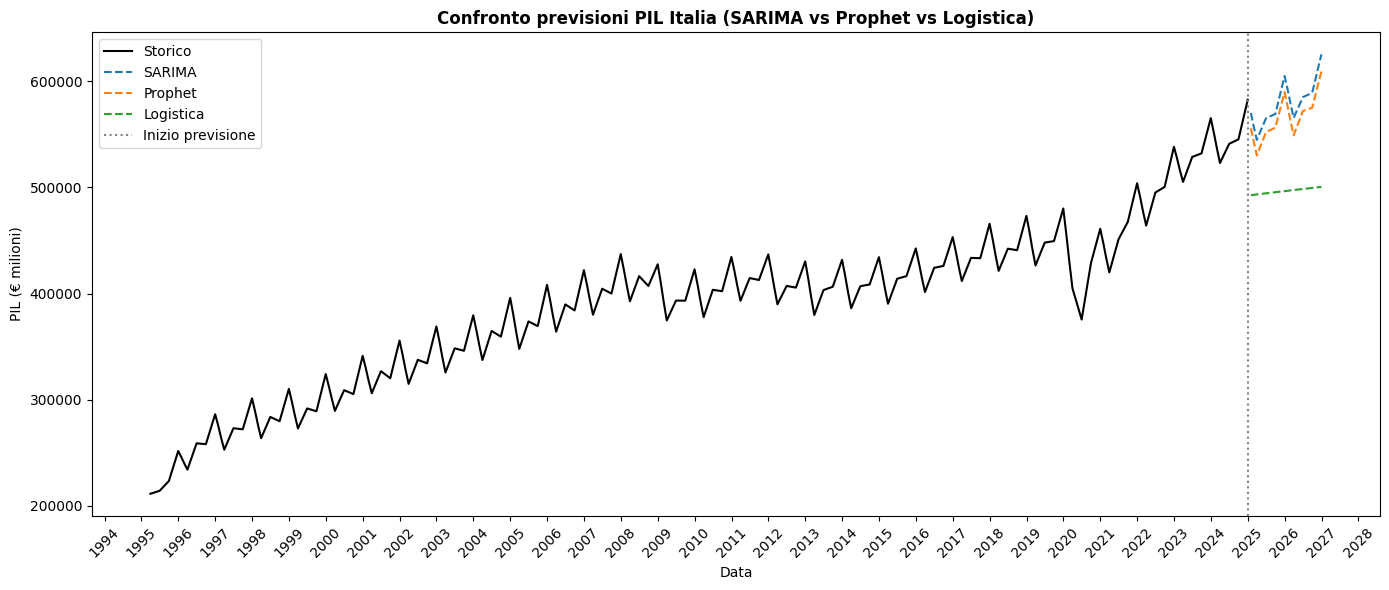

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from scipy.optimize import curve_fit

# === 0. Base: dati mensili reali ===
series = df_monthly['GDP'].dropna()
future_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1), periods=24, freq='ME')

# === 1. SARIMA ===
sarima_model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=24)

# === 2. Prophet ===
df_prophet = df_monthly.reset_index()[["Date", "GDP"]].dropna()
df_prophet.columns = ["ds", "y"]
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(df_prophet)
future_prophet = prophet_model.make_future_dataframe(periods=24, freq='ME')
forecast_prophet = prophet_model.predict(future_prophet)
prophet_forecast = forecast_prophet.set_index("ds").loc[future_dates, "yhat"]

# === 3. Logistica ===
def logistic(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

df_log = df_monthly.copy().dropna()
df_log["t"] = np.arange(len(df_log))
t = df_log["t"].values
y = df_log["GDP"].values
p0 = [max(y) * 1.1, 0.03, len(t)/2]
params, _ = curve_fit(logistic, t, y, p0=p0, maxfev=10000)
L, k, t0 = params
t_future = np.arange(len(t), len(t) + 24)
logistic_forecast = logistic(t_future, L, k, t0)

# === 4. Grafico comparativo ===
fig, ax = plt.subplots(figsize=(14, 6))

# Storico
ax.plot(series.index, series.values, label="Storico", color='black')

# Previsioni
ax.plot(future_dates, sarima_forecast, label="SARIMA", linestyle='--')
ax.plot(future_dates, prophet_forecast, label="Prophet", linestyle='--')
ax.plot(future_dates, logistic_forecast, label="Logistica", linestyle='--')

# Stilizzazione
ax.axvline(x=series.index[-1], color='gray', linestyle=':', label="Inizio previsione")
ax.set_title("Confronto previsioni PIL Italia (SARIMA vs Prophet vs Logistica)", fontweight='bold')
ax.set_ylabel("PIL (€ milioni)")
ax.set_xlabel("Data")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


# 📊 Previsioni del PIL per l'Italia nel 2025
Le previsioni del Prodotto Interno Lordo (PIL) dell'Italia per il 2025 variano leggermente tra i principali istituti e organizzazioni economiche, riflettendo un consenso su una crescita moderata. Ecco un confronto delle stime più recenti:([Il Post][1])



| Fonte                                      | Crescita prevista |                                                                                                      |
| ------------------------------------------ | ----------------- | ---------------------------------------------------------------------------------------------------- |
| **ISTAT**                                  | +0,8%             |                                                                                                      |
| **Commissione Europea**                    | +0,7%             |                                                                                                      |
| **Confindustria**                          | +0,6%             |                                                                                                      |
| **Banca d'Italia**                         | +0,6%             |                                                                                                      |
| **UPB (Ufficio Parlamentare di Bilancio)** | +0,8%             | ([Il Post][1], [Istat][2], [Reuters][3], [Ufficio Parlamentare di Bilancio][4], [Banca d'Italia][5]) |

### 🔍 Analisi delle previsioni

* **ISTAT**: Prevede una crescita del PIL dello 0,8% nel 2025, trainata principalmente dalla domanda interna, con i consumi delle famiglie sostenuti da un mercato del lavoro in miglioramento e da un incremento delle retribuzioni reali. Gli investimenti fissi lordi sono attesi stabili, influenzati dalla fine degli incentivi fiscali all'edilizia, ma compensati dall'attuazione delle misure previste dal PNRR e dalla riduzione dei tassi di interesse. ([Istat][2])

* **Commissione Europea**: Ha rivisto al ribasso le sue previsioni, stimando una crescita dello 0,7% per il 2025, rispetto all'1% precedentemente previsto. Questa revisione è attribuita all'indebolimento delle prospettive commerciali globali e all'aumento dell'incertezza sulle politiche commerciali. ([Sky TG24][6])

* **Confindustria**: Ha abbassato le sue stime di crescita al 0,6% per il 2025, citando l'impatto negativo delle politiche protezionistiche statunitensi e la fine degli incentivi fiscali all'edilizia. Tuttavia, sottolinea che la piena attuazione del PNRR e la riduzione dei tassi di interesse potrebbero fornire un impulso positivo all'economia. ([Istat][2])

* **Banca d'Italia**: Prevede una crescita del PIL dello 0,6% nel 2025, con un'espansione moderata sostenuta principalmente dai consumi. Le stime sono basate su informazioni disponibili fino al 2 aprile 2025. ([Banca d'Italia][5])

* **UPB**: L'Ufficio Parlamentare di Bilancio stima una crescita dello 0,8% nel 2025, evidenziando rischi al ribasso legati all'aumento dei costi energetici e alle tensioni commerciali globali. ([Ufficio Parlamentare di Bilancio][4])

### 📌 Conclusione

Le previsioni indicano una crescita moderata per l'economia italiana nel 2025, con stime che variano tra lo 0,6% e lo 0,8%. I principali fattori che influenzano queste previsioni includono la domanda interna, l'attuazione del PNRR, le politiche commerciali globali e le condizioni del mercato del lavoro.

Per un'analisi più dettagliata o per confrontare queste previsioni con quelle di altri paesi europei, è possibile consultare i rapporti completi delle rispettive istituzioni.

[1]: https://www.ilpost.it/2025/04/30/stime-istat-pil-italiano-primo-trimestre-2025-media-eurozona/?utm_source=chatgpt.com "Nel primo trimestre del 2025 l'economia italiana è cresciuta, ma ..."
[2]: https://www.istat.it/comunicato-stampa/le-prospettive-per-leconomia-italiana-nel-2024-2025-2/?utm_source=chatgpt.com "Le prospettive per l'economia italiana nel 2024-2025 - Istat"
[3]: https://www.reuters.com/markets/europe/italy-business-lobby-lowers-gdp-forecast-us-tariffs-loom-2025-04-02/?utm_source=chatgpt.com "Italy business lobby lowers GDP forecast as U.S. tariffs loom"
[4]: https://www.upbilancio.it/nota-sulla-congiuntura-di-febbraio-2025-lupb-aggiorna-le-stime-sul-pil-alla-luce-dei-rischi-globali/?utm_source=chatgpt.com "L'UPB aggiorna le stime sul PIL alla luce dei rischi globali"
[5]: https://www.bancaditalia.it/pubblicazioni/proiezioni-macroeconomiche/2025/Proiezioni-macroeconomiche-Italia-aprile-2025.pdf?utm_source=chatgpt.com "[PDF] 4 aprile 2025 - Banca d'Italia"
[6]: https://tg24.sky.it/economia/2025/05/19/ue-pil-italia-stima-2025-2026?utm_source=chatgpt.com "Pil, Ue taglia le stime di crescita dell'Italia del 2025 a +0,7%"


In [68]:
# Costruzione DataFrame comparativo
df_previsioni = pd.DataFrame({
    "Date": future_dates,
    "SARIMA": sarima_forecast.values,
    "Prophet": prophet_forecast.values,
    "Logistica": logistic_forecast
})
df_previsioni = df_previsioni.set_index("Date")

# Arrotonda per leggibilità
df_previsioni = df_previsioni.round(2)

# Mostra le prime righe
print("\n📊 Previsioni PIL Italia (prossimi 24 mesi):")
print(df_previsioni.head(12).to_string())



📊 Previsioni PIL Italia (prossimi 24 mesi):
               SARIMA    Prophet  Logistica
Date                                       
2025-01-31  570234.50  555842.87  492684.03
2025-02-28  557591.63  543520.47  493042.98
2025-03-31  544828.75  530079.20  493400.28
2025-04-30  551681.21  537480.62  493755.93
2025-05-31  558494.65  544894.69  494109.94
2025-06-30  565285.85  552224.16  494462.31
2025-07-31  566607.76  553618.83  494813.04
2025-08-31  567922.45  555043.40  495162.14
2025-09-30  569233.01  556357.79  495509.62
2025-10-31  581156.77  567484.54  495855.48
2025-11-30  593079.19  578618.04  496199.73
2025-12-31  605000.84  589843.87  496542.36


# Backup

In [4]:
import nbformat
from nbconvert import HTMLExporter
from pathlib import Path

# === CONFIGURAZIONE ===
nb_name = "PIL_previsioni"  # <-- senza estensione
input_path = Path(f"{nb_name}.ipynb")
output_path = Path(f"D:/paolovolterra.github.io/Eurostat/docs/{nb_name}.html")

# === CREA CARTELLA DI OUTPUT SE NECESSARIA ===
output_path.parent.mkdir(parents=True, exist_ok=True)

# === CARICA NOTEBOOK ===
print("📖 Carico il notebook…")
with input_path.open("r", encoding="utf-8") as f:
    nb_node = nbformat.read(f, as_version=4)

# === CONVERSIONE IN HTML ===
print("🌀 Converto in HTML…")
exporter = HTMLExporter()
exporter.exclude_input_prompt = True
exporter.exclude_output_prompt = True
exporter.template_name = "classic"

# === CSS PERSONALIZZATO (opzionale) ===
custom_css = """
<style>
body {
    font-family: 'Segoe UI', sans-serif;
    margin: 40px;
    line-height: 1.6;
    color: #333;
}
h1, h2, h3 {
    color: #007a53;
    border-bottom: 1px solid #ddd;
    padding-bottom: 0.3em;
}
code {
    background-color: #f8f8f8;
    padding: 0.2em 0.4em;
    border-radius: 4px;
    font-size: 90%;
}
pre {
    background-color: #f4f4f4;
    padding: 1em;
    border-radius: 6px;
    overflow-x: auto;
}
</style>
"""

(body, resources) = exporter.from_notebook_node(nb_node)

# Inserisce CSS nell'head
body = body.replace("</head>", f"{custom_css}\n</head>")

# === SALVA HTML ===
output_path.write_text(body, encoding="utf-8")
print(f"✅ Salvato in: {output_path.resolve()}")


📖 Carico il notebook…
🌀 Converto in HTML…
✅ Salvato in: D:\paolovolterra.github.io\Eurostat\docs\PIL_previsioni.html


In [6]:
from pathlib import Path
from shutil import copyfile
import nbformat
from nbconvert import HTMLExporter

# === CONFIGURAZIONE ===
nb_name = "PIL_previsioni"  # <-- senza estensione
src_ipynb = Path(f"{nb_name}.ipynb")
dst_ipynb = Path(f"D:/paolovolterra.github.io/Eurostat/{src_ipynb.name}")
dst_html = Path(f"D:/paolovolterra.github.io/Eurostat/docs/{nb_name}.html")

# === CREA CARTELLE SE NECESSARIO ===
dst_ipynb.parent.mkdir(parents=True, exist_ok=True)
dst_html.parent.mkdir(parents=True, exist_ok=True)

# === 1. COPIA NOTEBOOK ORIGINALE ===
copyfile(src_ipynb, dst_ipynb)
print(f"📁 Notebook copiato in: {dst_ipynb.resolve()}")

# === 2. CONVERSIONE IN HTML (CON CODICE) ===
print("🌀 Converto in HTML con codice…")
with src_ipynb.open("r", encoding="utf-8") as f:
    nb_node = nbformat.read(f, as_version=4)

html_exporter = HTMLExporter()
html_exporter.exclude_input = False  # Mostra codice
html_exporter.exclude_output_prompt = True
html_exporter.exclude_input_prompt = True
html_exporter.template_name = "classic"

# === STILE CSS PERSONALIZZATO (opzionale) ===
custom_css = """
<style>
body {
    font-family: 'Segoe UI', sans-serif;
    margin: 40px;
    line-height: 1.6;
    color: #333;
}
h1, h2, h3 {
    color: #007a53;
    border-bottom: 1px solid #ddd;
    padding-bottom: 0.3em;
}
code {
    background-color: #f8f8f8;
    padding: 0.2em 0.4em;
    border-radius: 4px;
    font-size: 90%;
}
pre {
    background-color: #f4f4f4;
    padding: 1em;
    border-radius: 6px;
    overflow-x: auto;
}
</style>
"""

# === GENERA HTML ===
body, _ = html_exporter.from_notebook_node(nb_node)
body = body.replace("</head>", f"{custom_css}\n</head>")

# === SALVA HTML ===
dst_html.write_text(body, encoding="utf-8")
print(f"✅ HTML esportato in: {dst_html.resolve()}")


📁 Notebook copiato in: D:\paolovolterra.github.io\Eurostat\PIL_previsioni.ipynb
🌀 Converto in HTML con codice…
✅ HTML esportato in: D:\paolovolterra.github.io\Eurostat\docs\PIL_previsioni.html
